# Mask R-CNN - Inspect MICCAI model weights

This notebook shows how to inspect Mask R-CNN weights found for MICCAI16 dataset

In [1]:
import os
import sys
import datetime
import numpy as np
import skimage.draw
import SimpleITK as sitk
import matplotlib.pylab as plt
from imgaug import augmenters as iaa



# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import visualize
from mrcnn.visualize import display_images

# Path to trained weights file
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_WEIGHTS_PATH):
    utils.download_trained_weights(COCO_WEIGHTS_PATH)
    

MICCAI16_WEIGHTS_PATH = os.path.join(ROOT_DIR, "logs/MICCAI/mask_rcnn_miccai_0036.h5")
                                     #"logs/miccai_20px_resnet101/mask_rcnn_miccai_0036.h5")
WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


Using TensorFlow backend.


# Configuration

In [2]:

class MiccaiConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "Miccai"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 5

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + 1 Lesion

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 400

    # Skip detections with < 90% confidence
    #DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_MIN_CONFIDENCE = 0.9
    
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384
    
    # Image mean (RGB)
    MEAN_PIXEL = np.array([0.13, 0.13, 0.13])
    
    # BACKBONE_STRIDES for computing feature map size
    
    # Length of square anchor side in pixels
    #RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56) 
    
class MiccaiInferenceConfig(MiccaiConfig):
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Non-max suppression threshold to filter RPN proposals.
    RPN_NMS_THRESHOLD = 0.7

## Dataset

Load Miccai dataset

Override the following methods:

* load_image()
* load_mask()
* image_reference()

In [3]:
from skimage import measure
from tools import separate_mask

class MiccaiDataset(utils.Dataset):
    
    def load_miccai_dataset(self, dataset_dir,subset):
        """Load a subset of the dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have 1 classe and backround is initialized per default
        self.add_class("Miccai", 1, "Lesion")
        
        assert subset in ["train", "validation", "test"]
        
        dataset_dir = os.path.join(dataset_dir, "Miccai_example_data")
        
        image_ids = []
        
        # r=root, d=directories, f = files
        for r, d, f in os.walk(dataset_dir):
            for file in f:    
                if '3DFLAIR' in file:
                    image_ids.append(os.path.join(r, file))

        nb_image = len(image_ids)
        
        print("nombre image 2D : ", nb_image)

        for image_id in image_ids:
            img_name = os.path.basename(image_id)
            self.add_image(
                "Miccai",
                image_id=img_name[len("3DFLAIR_"):len(img_name)-len(".nii.gz")],
                path=image_id)
                

            
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        #dataset_dir = os.path.join(os.path.dirname(info['path']), "Consensus.nii.gz")
        image_info = self.image_info[image_id]
        #print("image_info = ", image_info)
        
        img_name = os.path.dirname(image_info['path'])
        #print("info id ", image_info['id'])
        #print("info path ", image_info['path'])
        mask_id = os.path.join(os.path.dirname(image_info['path']), "Consensus_" + 
                               str(image_info['id']) + ".nii.gz")
    
        #mask_id = os.path.join(os.path.dirname(image_info['path']), "Consensus_"+(image_info['id'][8:11])+".nii.gz")
        #print("mask id = ", mask_id)
            
        
        mask=sitk.GetArrayFromImage(sitk.ReadImage(mask_id, sitk.sitkUInt8))
        #sitkFloat32))
        
        num_pixel_treshold = 10
        mask = separate_mask(mask, num_pixel_treshold)
        
        count_non_zero = np.count_nonzero(mask) 

        if count_non_zero < num_pixel_treshold:
            # no mask
            mask = np.zeros((mask.shape[0], mask.shape[1], 1))
            class_ids = np.zeros(1, np.int32)
            #print("no mask")
            #print("class_ids = ", class_ids.shape)
        
        else:
            class_ids = np.ones([mask.shape[-1]], dtype=np.int32)
            #print("class_ids = ", class_ids.shape)
        
        #print("mask shape = ", mask.shape)
        #print("class_ids = ", class_ids.shape)
        
        #for i in range(0, class_ids.shape[0]):
         #   plt.figure()
          #  plt.imshow(mask[:,:,i], cmap='gray')
           # plt.axis('off')
            #plt.show()
        
        return mask.astype(np.bool), class_ids
        
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "Miccai":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
    
    def load_image (self, image_id):
        #print("load image")
        # we can use next image_reference function instead of image_info
        #print("path image id = ", self.image_info[image_id]['path'])
        image=sitk.GetArrayFromImage(sitk.ReadImage(self.image_info[image_id]['path'], sitk.sitkFloat32))

        image[image < 0] = 0

        image=np.stack((image,image,image),axis=2)
        
        #plt.figure()
        #plt.imshow(image, cmap='gray')
        #plt.axis('off')
        #plt.show()
        
        #print("shape image before returning : ", image.shape)
        # mean pixels in all dataset :  0.13044332
        # std pixels in all dataset :  0.28245687

        return image



**Load dataset and apply data augmentation**


In [6]:
# Training dataset.
dataset_dir = "/floyd/input"

# Test dataset
dataset_test = MiccaiDataset()
dataset_test.load_miccai_dataset(dataset_dir, "test")
dataset_test.prepare()

print("Image Count: {}".format(len(dataset_test.image_ids)))
print("Class Count: {}".format(dataset_test.num_classes))
for i, info in enumerate(dataset_test.class_info):
    print("{:3}. {:50}".format(i, info['name']))

dataset = dataset_test

Image Count: 305
Class Count: 2
  0. BG                                                
  1. Lesion                                            


**Test avec les valeurs de weights trouvés après l'entraînement**

Inference

In [7]:
infConf=MiccaiInferenceConfig()
infConf.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [8]:
model = modellib.MaskRCNN(mode="inference", 
                          config=infConf,
                          model_dir=MODEL_DIR)

# def detect (model, image_path=None):
init_with = "custom"  # imagenet, coco, or last or custom

if init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)
elif init_with == "custom":
    model_path = MICCAI16_WEIGHTS_PATH
    
    # Load trained weights
    print("Loading weights from ", model_path)
    model.load_weights(model_path, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /floyd/home/logs/MICCAI/mask_rcnn_miccai_0036.h5


In [9]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

119
original_image           shape: (384, 384, 3)         min:    0.00000  max:    1.62300  float32
image_meta               shape: (14,)                 min:    0.00000  max:  384.00000  float64
gt_class_id              shape: (8,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (8, 4)                min:  112.00000  max:  310.00000  int32
gt_mask                  shape: (384, 384, 8)         min:    0.00000  max:    1.00000  bool


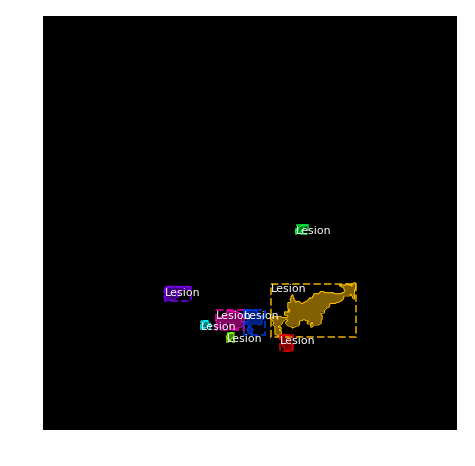

Processing 1 images
image                    shape: (384, 384, 3)         min:    0.00000  max:    1.62300  float32
molded_images            shape: (1, 384, 384, 3)      min:   -0.13000  max:    1.49300  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  int64
anchors                  shape: (1, 36828, 4)         min:   -0.47264  max:    1.30553  float32
[1 1 1 1 1 1] vs [1 1 1 1 1 1 1 1]


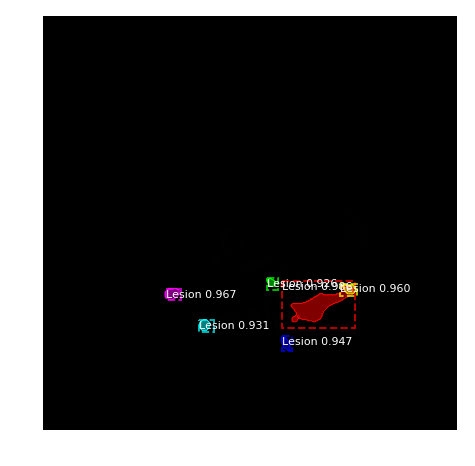

In [11]:
import tensorflow as tf
with tf.device("/gpu:0"):
    image_id = np.random.choice(dataset.image_ids)
    #image_id = 209
    print(image_id)

    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, infConf, 
                               image_id, use_mini_mask=False)
    from mrcnn.model import log
    log("original_image", original_image)
    log("image_meta", image_meta)
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)

    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))

    #segmentation
    results = model.detect([original_image], verbose=1)

    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=get_ax())
    print(r['class_ids'],"vs",gt_class_id)
    #print("scores :", r['scores'])
    #print(r['rois'])
    #print(r['masks'])

## Run Detection

In [12]:
from medpy import metric
voxel_spacing = [1.0, 1.0]

def dice_one_mask(gt_mask,r):
    res=0.0
    try:
        # merge all instances of lesion on a single mask
        for i in range (0,r['masks'].shape[2]):
            if i==0:
                r_mask_unique = r['masks'][:,:,i]
            else:
                r_mask_unique += r['masks'][:,:,i]
        
        # merge all instances of lesion on a single mask
        for j in range (0,gt_mask.shape[2]):
            if j==0:
                gt_mask_unique = gt_mask[:,:,j]
            else:
                gt_mask_unique += gt_mask[:,:,j]
        res = metric.binary.dc(r_mask_unique, gt_mask_unique)
        return res
    except :#IndexError:
        #print("Exception !!! ")
        return 10000

def assd_one_mask (gt_mask,r):
    res=0.0
    try:
        for i in range (0,r['masks'].shape[2]):
            if i==0:
                r_mask_unique = r['masks'][:,:,i]
            else:
                r_mask_unique += r['masks'][:,:,i]
        for j in range (0,gt_mask.shape[2]):
            if j==0:
                gt_mask_unique = gt_mask[:,:,j]
            else:
                gt_mask_unique += gt_mask[:,:,j]
        
        res+=metric.binary.assd(r_mask_unique,gt_mask_unique,voxelspacing=[voxel_spacing[1], voxel_spacing[0]])
        
        return res
    except :#IndexError:
        #print("Exception !!! ")
        return 10000
        
def hd_one_mask (gt_mask,r):
    res=0.0
    try:
        for i in range (0,r['masks'].shape[2]):
            if i==0:
                r_mask_unique = r['masks'][:,:,i]
            else:
                r_mask_unique += r['masks'][:,:,i]
        for j in range (0,gt_mask.shape[2]):
            if j==0:
                gt_mask_unique = gt_mask[:,:,j]
            else:
                gt_mask_unique += gt_mask[:,:,j]
        
        res+=metric.binary.hd(r_mask_unique,gt_mask_unique,voxelspacing=[voxel_spacing[1], voxel_spacing[0]])
        
        return res
    except :#IndexError:
        #print("Exception !!! ")
        return 10000
        

In [13]:
def dice_mask_sep(gt_mask,r):
    # keep separate instances of lesions
    # ATTENTION!!! 
    # THIS PART MUST BE REVIEWED !!!!
    # some cases aren't handled 
    res=0.0
    try:
        for i in range (0,r['masks'].shape[2]):
            if (r['masks'].any()):
                cpt=0
                aa=0
                for j in range(0,gt_mask.shape[2]):
                    a = metric.binary.dc(r['masks'][:,:,i], gt_mask[:,:,j])
                    if(a!=0):
                        cpt+=1
                        aa+=a
                if (aa !=0) and (cpt!=0):
                    res+=aa/cpt
                    
        return res/(float)(r['masks'].shape[2])
    except :#IndexError:
        #print("Exception !!! ")
        return 10000

image ID: Miccai.066 (131) /floyd/input/miccai_preprocess/08029IVDI/3DFLAIR_066.nii.gz
Original image shape:  [336 336   3]
Processing 1 images
image                    shape: (384, 384, 3)         min:    0.00000  max:    1.31125  float32
molded_images            shape: (1, 384, 384, 3)      min:    0.00000  max:    1.31125  float32
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 36828, 4)         min:   -0.47264  max:    1.30553  float32
gt_class_id              shape: (4,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (4, 4)                min:  190.00000  max:  328.00000  int32
gt_mask                  shape: (384, 384, 4)         min:    0.00000  max:    1.00000  bool
AP @0.50:	 0.000
AP @0.55:	 0.000
AP @0.60:	 0.000
AP @0.65:	 0.000
AP @0.70:	 0.000
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.000

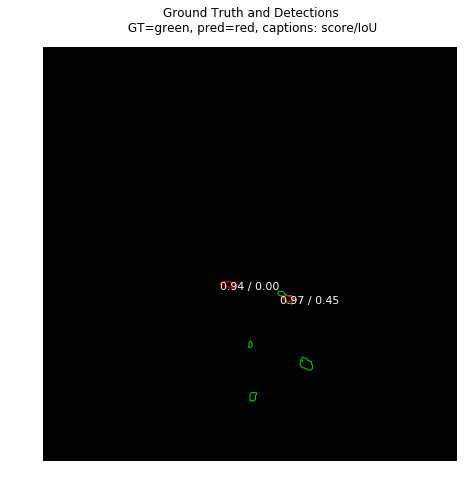

In [15]:
image_id = np.random.choice(dataset.image_ids)
#image_id = 168
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, infConf, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

print("dice one mask = ", dice_one_mask(gt_mask,r))
#print("dice mask separated = ", dice_mask_sep(gt_mask,r))

### Compute AP on Batch of Images

In [16]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, infConf,
                                   image_id, use_mini_mask=False)
        
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 10
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [336 336   3]   AP: 0.18
  1 [336 336   3]   AP: 0.05
  2 [336 336   3]   AP: 0.29
  3 [336 336   3]   AP: 0.23
  4 [336 336   3]   AP: 0.17
  5 [336 336   3]   AP: 0.10
  6 [336 336   3]   AP: 0.00
  7 [336 336   3]   AP: 0.05
  8 [336 336   3]   AP: 0.17
  9 [336 336   3]   AP: 0.18
Mean AP overa 10 images: 0.1425


In [33]:
#image_ids = np.random.choice(dataset.image_ids, 2)
#print(image_ids)

image_ids = dataset.image_ids

APs = []
#DICEsep = []
DICEs = []
HDs = []
ASSDs = []

for image_id in image_ids:
   # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
                modellib.load_image_gt(dataset, infConf,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, infConf), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"], r["class_ids"], r["scores"], r['masks'])
        
        #visualize.plot_precision_recall(AP, precisions, recalls)
        
        APs.append(AP)
        
        # Compute dice 
        #print(image_id)
        #DICEsep.append(dice_mask_sep(gt_mask,r))
        DICEs.append(dice_one_mask(gt_mask,r))
        ASSDs.append(assd_one_mask(gt_mask,r))
        HDs.append(hd_one_mask(gt_mask,r))


In [34]:
DICEs = np.array(DICEs)
test = np.where(DICEs<10000)
#if len(test[1]) != DICEs.shape[1]:
 #   print("number of exceptions DICE = ", DICEs.shape[1]-len(test[1]))
DICEs = np.array([DICEs[i] for i in test])
print('mean dice one mask :',np.mean(DICEs))
print('std dice one mask :',np.std(DICEs))

ASSDs = np.array(ASSDs)
test = np.where(ASSDs<10000)
#if len(test[1]) != ASSDs.shape[1]:
 #   print("number of exceptions ASD = ", ASSDs.shape[1]-len(test[1]))
ASSDs = np.array([ASSDs[i] for i in test])
print('mean assd :',np.mean(ASSDs))

HDs = np.array(HDs)
test = np.where(HDs<10000)
#if len(test[1]) != HDs.shape[1]:
 #   print("number of exceptions HD = ", HDs.shape[1]-len(test[1]))
HDs = np.array([HDs[i] for i in test])
print('mean hd :',np.mean(HDs))
        
#DICEsep = np.array(DICEsep)
#test = np.where(DICEsep<10000)
#DICEsep = np.array([DICEsep[i] for i in test])
#print('mean dice mask sep:',np.mean(DICEsep))
#print('std dice mask sep:',np.std(DICEsep))


APs = np.array(APs)
print('mean mAPs :',np.mean(APs))
print('std mAPs :',np.std(APs))

mean dice one mask : 0.5426517128377654
std dice one mask : 0.2260795470178622
mean assd : 12.17784415887303
mean hd : 51.48294268481871
mean mAPs : 0.3448580635669383
std mAPs : 0.3332651618734267


In [37]:
# remove nan values in APs if there are
filter = ~np.isnan(APs)
APs = APs[filter]

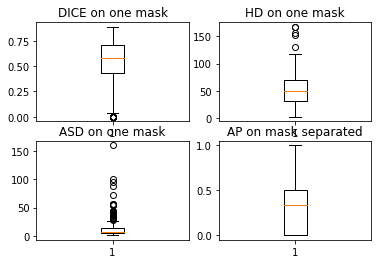

In [38]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.boxplot(np.squeeze(DICEs))

ax2 = fig.add_subplot(222)
ax2.boxplot(np.squeeze(HDs))

ax3 = fig.add_subplot(223)
ax3.boxplot(np.squeeze(ASSDs))

ax4 = fig.add_subplot(224)
ax4.boxplot(np.squeeze(APs))

ax1.title.set_text('DICE on one mask')
ax2.title.set_text('HD on one mask')
ax3.title.set_text('ASD on one mask')
ax4.title.set_text('AP on mask separated')
plt.show()

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

215
original_image           shape: (384, 384, 3)         min:    0.00000  max:    1.65784  float32
image_meta               shape: (14,)                 min:    0.00000  max:  384.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:  186.00000  max:  326.00000  int32
gt_mask                  shape: (384, 384, 2)         min:    0.00000  max:    1.00000  bool


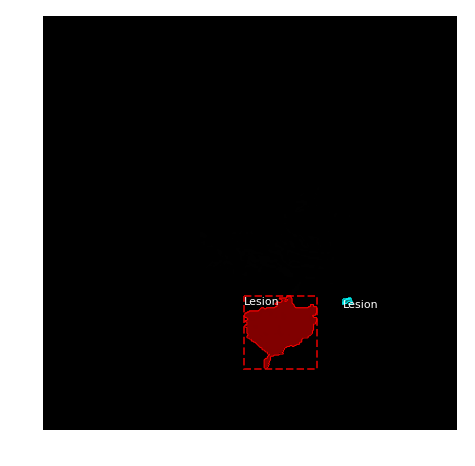

Processing 1 images
image                    shape: (384, 384, 3)         min:    0.00000  max:    1.65784  float32
molded_images            shape: (1, 384, 384, 3)      min:   -0.13000  max:    1.52784  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  int64
anchors                  shape: (1, 36828, 4)         min:   -0.47264  max:    1.30553  float32
[1 1] vs [1 1]


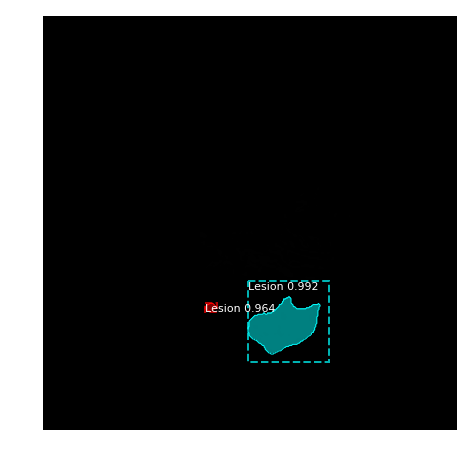

In [40]:
image_id = np.random.choice(dataset.image_ids)
print(image_id)

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, infConf, 
                           image_id, use_mini_mask=False)
from mrcnn.model import log
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                        dataset.class_names, figsize=(8, 8))

#segmentation
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                        dataset.class_names, r['scores'], ax=get_ax())
print(r['class_ids'],"vs",gt_class_id)
image = original_image

In [41]:
# Get anchors and convert to pixel coordinates
anchors = model.get_anchors(image.shape)
anchors = utils.denorm_boxes(anchors, image.shape[:2])
log("anchors", anchors)

# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = anchors[positive_anchor_ix]
negative_anchors = anchors[negative_anchor_ix]
neutral_anchors = anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

anchors                  shape: (36828, 4)            min: -181.00000  max:  501.00000  int32
target_rpn_match         shape: (36828,)              min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -5.81575  max:    2.18750  float64
positive_anchors         shape: (7, 4)                min:  192.00000  max:  320.00000  int32
negative_anchors         shape: (249, 4)              min:  -91.00000  max:  397.00000  int32
neutral anchors          shape: (36572, 4)            min: -181.00000  max:  501.00000  int32
refined_anchors          shape: (7, 4)                min:  186.00000  max:  326.00000  float32


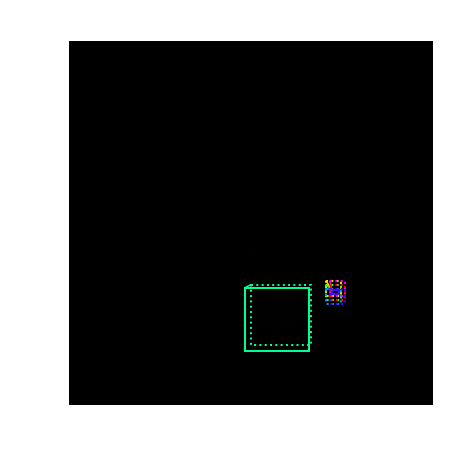

In [42]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=positive_anchors,
    refined_boxes=refined_anchors)

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [43]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph(image[np.newaxis], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
], image_metas=image_meta[np.newaxis])

rpn_class                shape: (1, 36828, 2)         min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.47264  max:    1.30553  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.66704  max:    1.38771  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 1268.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.09102  max:    0.98424  float32


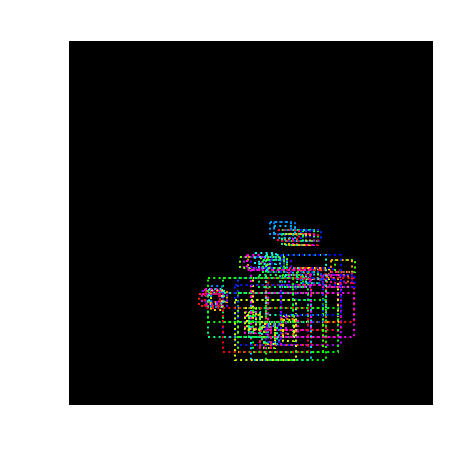

In [44]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=anchors[sorted_anchor_ids[:limit]], ax=get_ax())

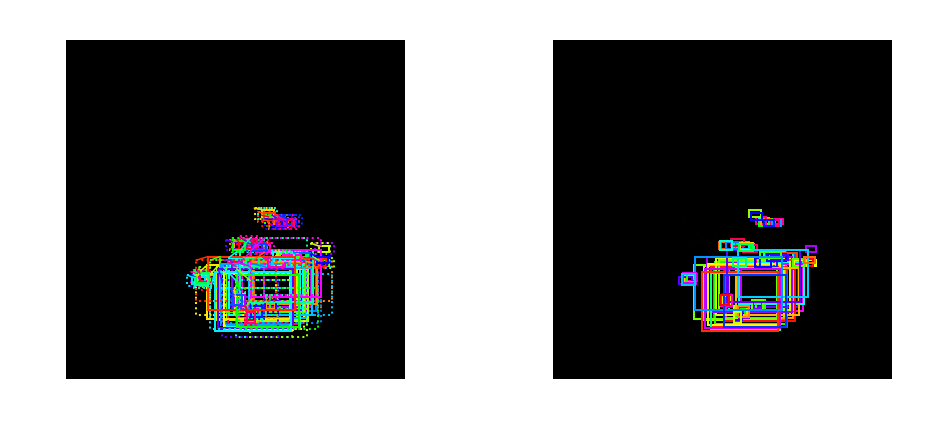

In [45]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 100
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

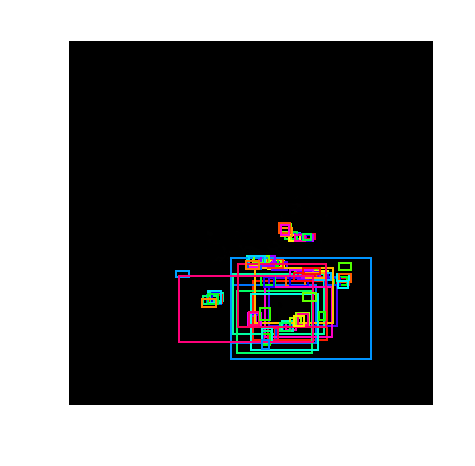

In [46]:
# Show refined anchors after non-max suppression
limit = 100
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

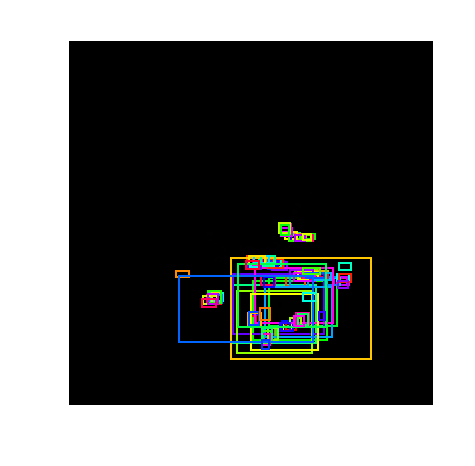

In [47]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 100
# Convert back to image coordinates for display
# h, w = config.IMAGE_SHAPE[:2]
# proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(
    image, ax=get_ax(),
    refined_boxes=utils.denorm_boxes(rpn['proposals'][0, :limit], image.shape[:2]))

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

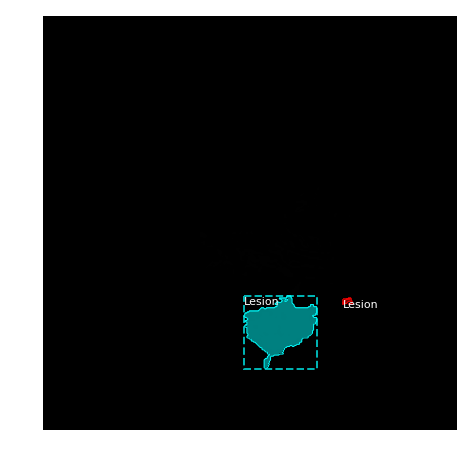

In [48]:
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                        dataset.class_names, figsize=(8, 8))

In [49]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.09103  max:    0.98420  float32
probs                    shape: (1, 1000, 2)          min:    0.00043  max:    0.99957  float32
deltas                   shape: (1, 1000, 2, 4)       min:   -2.63296  max:    3.23390  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00001  max:    0.99642  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32


2 detections: ['Lesion' 'Lesion']


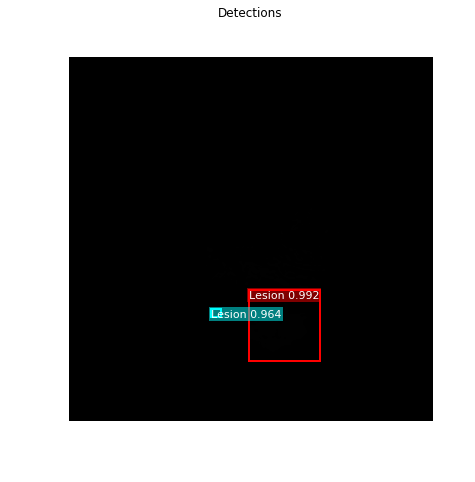

In [50]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [51]:
# Proposals are in normalized coordinates
proposals = mrcnn["proposals"][0]

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
39 Positive ROIs
[('BG', 961), ('Lesion', 39)]


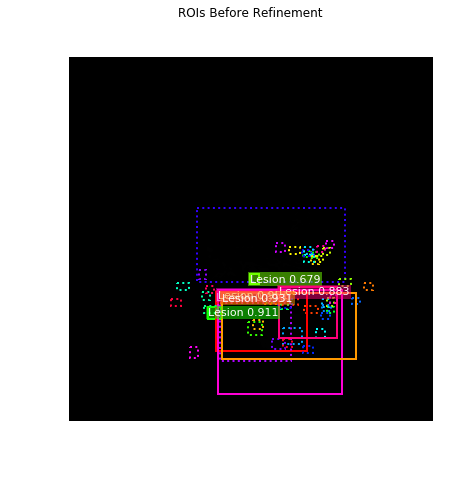

In [52]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 50
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
    captions=captions, title="ROIs Before Refinement",
    ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -2.31950  max:    2.52933  float32
refined_proposals        shape: (1000, 4)             min:    0.03631  max:    1.04965  float32


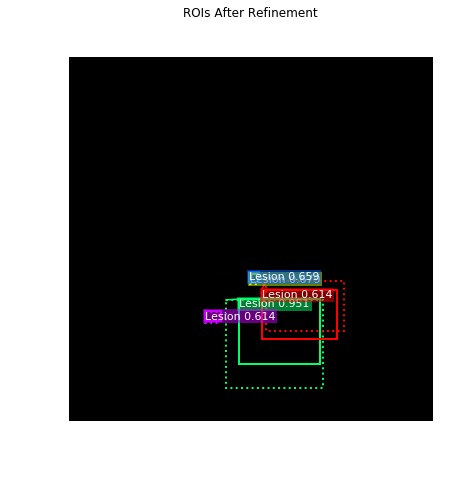

In [53]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * infConf.BBOX_STD_DEV)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=utils.denorm_boxes(proposals[roi_positive_ixs][ids], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[roi_positive_ixs][ids], image.shape[:2]),
    visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
    captions=captions, title="ROIs After Refinement")

#### Filter Low Confidence Detections

In [54]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 39 detections:
[  2   3   6  10  14  21  22  26  33  35  48  49  50  54  58  67  69  82
  95 104 120 130 141 155 209 219 231 325 328 337 339 471 509 533 571 601
 685 754 909]


In [55]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= infConf.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    infConf.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.9 confidence. Keep 17:
[  2   3  10  22  26  33  35  48  50  54 130 231 337 471 533 571 909]


#### Per-Class Non-Max Suppression

In [56]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            infConf.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

Lesion                : [  2   3  10  22  26  33  35  48  50  54 130 231 337 471 533 571 909] -> [571  48]

Kept after per-class NMS: 2
[ 48 571]


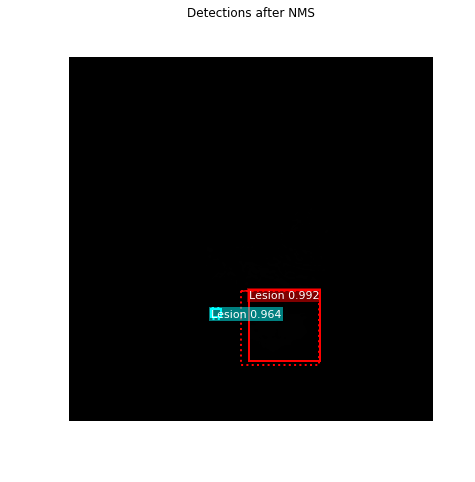

In [57]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[keep][ixs], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[keep][ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

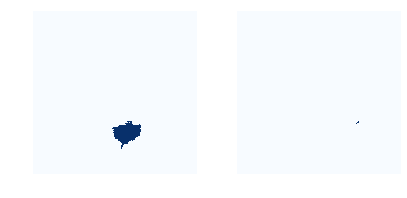

In [58]:
limit = 8
display_images(np.transpose(gt_mask[..., :limit], [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [59]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00001  max:    0.99642  float32
2 detections: ['Lesion' 'Lesion']


In [60]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (2, 28, 28)           min:    0.00018  max:    0.99642  float32
det_masks                shape: (2, 384, 384)         min:    0.00000  max:    1.00000  bool


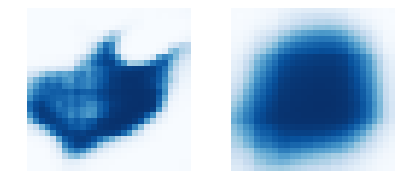

In [61]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

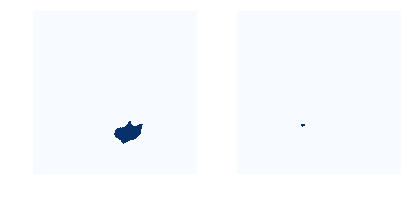

In [62]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [63]:
# Get activations of a few sample layers
import tensorflow as tf
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 384, 384, 3)      min:   -0.13000  max:    1.52784  float32
res2c_out                shape: (1, 96, 96, 256)      min:    0.00000  max:   21.16242  float32
res3c_out                shape: (1, 48, 48, 512)      min:    0.00000  max:   27.53976  float32
rpn_bbox                 shape: (1, 36828, 4)         min:  -17.21289  max:   17.89811  float32
roi                      shape: (1, 1000, 4)          min:    0.09103  max:    0.98420  float32


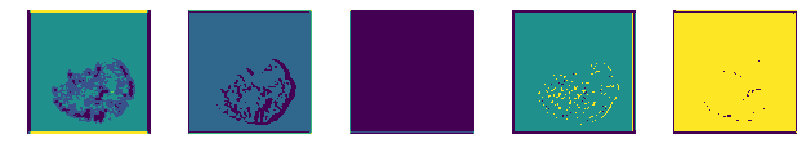

In [64]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:5], [2, 0, 1]), cols=5)